# LME銅 Cash/3Mスプレッド価格可視化分析

## 分析目的
このノートブックは、LME銅Cash/3Mスプレッド（CMCU0-CMCU3）の包括的な可視化分析を行います：
1. **スプレッドトレンド分析**: 長期・短期のスプレッド動向
2. **ボラティリティ分析**: スプレッド変動の特性
3. **出来高分析**: 取引活動とスプレッドの関係
4. **テクニカル分析**: 移動平均、ボリンジャーバンド等
5. **季節性分析**: 年間・月間パターン
6. **リスク指標**: VaR、最大ドローダウン等

## データ概要
- **期間**: 2022年7月〜2025年7月（約3年間）
- **頻度**: 日次データ
- **スプレッド**: Cash - 3M (USD/tonne)
- **解釈**: 正値=バックワーデーション、負値=コンタンゴ
- **通貨**: USD

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✓ Plotly available for interactive charts")
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    import mplfinance as mpf
    MPF_AVAILABLE = True
    print("✓ mplfinance available for candlestick charts")
except ImportError:
    print("mplfinance not available. Using matplotlib for price charts.")
    MPF_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [15, 10]

print("✓ ライブラリ読み込み完了")
print("Ready for LME Cash/3M spread analysis")

✓ Plotly available for interactive charts
mplfinance not available. Using matplotlib for price charts.
✓ ライブラリ読み込み完了
Ready for LME Cash/3M spread analysis


## データ読み込みと前処理

In [2]:
def load_cash_3m_spread_data():
    """LME銅Cash/3Mスプレッドデータを読み込み"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            ric,
            last_price as spread_price,
            high_price,
            low_price,
            open_price,
            volume,
            currency
        FROM lme_copper_prices
        WHERE price_type = 'CASH_3M_SPREAD'
        AND last_price IS NOT NULL
        ORDER BY trade_date
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # データ前処理
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        
        # 数値型に変換
        price_columns = ['spread_price', 'high_price', 'low_price', 'open_price']
        for col in price_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
        
        # 基本統計情報
        print(f"データ読み込み完了: {len(df):,}件のレコード")
        print(f"期間: {df.index.min().date()} ～ {df.index.max().date()}")
        print(f"RIC: {df['ric'].iloc[0]}")
        print(f"通貨: {df['currency'].iloc[0]}")
        
        return df
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None

# データ読み込み
cash_3m_spread = load_cash_3m_spread_data()

if cash_3m_spread is not None:
    print(f"\n基本統計:")
    print(f"平均スプレッド: ${cash_3m_spread['spread_price'].mean():,.2f}")
    print(f"最大スプレッド: ${cash_3m_spread['high_price'].max():,.2f}")
    print(f"最小スプレッド: ${cash_3m_spread['low_price'].min():,.2f}")
    print(f"平均出来高: {cash_3m_spread['volume'].mean():,.0f} ロット")
    print(f"最大出来高: {cash_3m_spread['volume'].max():,.0f} ロット")
    
    # データ品質チェック
    missing_prices = cash_3m_spread['spread_price'].isna().sum()
    missing_volume = cash_3m_spread['volume'].isna().sum()
    print(f"\nデータ品質:")
    print(f"価格欠損: {missing_prices}件")
    print(f"出来高欠損: {missing_volume}件")
    
    # コンタンゴ/バックワーデーション統計
    backwardation_days = (cash_3m_spread['spread_price'] > 0).sum()
    contango_days = (cash_3m_spread['spread_price'] < 0).sum()
    total_days = len(cash_3m_spread)
    
    print(f"\n市場構造統計:")
    print(f"バックワーデーション: {backwardation_days}日 ({backwardation_days/total_days*100:.1f}%)")
    print(f"コンタンゴ: {contango_days}日 ({contango_days/total_days*100:.1f}%)")
    
    # 最新5日間のデータ確認
    print(f"\n最新データ:")
    print(cash_3m_spread[['spread_price', 'volume']].tail())

データ読み込み完了: 758件のレコード
期間: 2022-07-06 ～ 2025-07-04
RIC: CMCU0-3
通貨: USD

基本統計:
平均スプレッド: $-49.86
最大スプレッド: $379.00
最小スプレッド: $-179.50
平均出来高: 61 ロット
最大出来高: 612 ロット

データ品質:
価格欠損: 0件
出来高欠損: 28件

市場構造統計:
バックワーデーション: 142日 (18.7%)
コンタンゴ: 615日 (81.1%)

最新データ:
            spread_price  volume
trade_date                      
2025-06-30        181.69    24.0
2025-07-01        116.30    50.0
2025-07-02         96.20    12.0
2025-07-03         87.61   225.0
2025-07-04         82.00    10.0


## 1. 基本的なスプレッドチャート

### 解釈ガイド:
- **正値 (>0)**: バックワーデーション（需給タイト、現物プレミアム）
- **負値 (<0)**: コンタンゴ（供給過多、貯蔵コスト反映）
- **ゼロライン**: 市場の均衡点
- **ボラティリティ**: 市場ストレスの指標

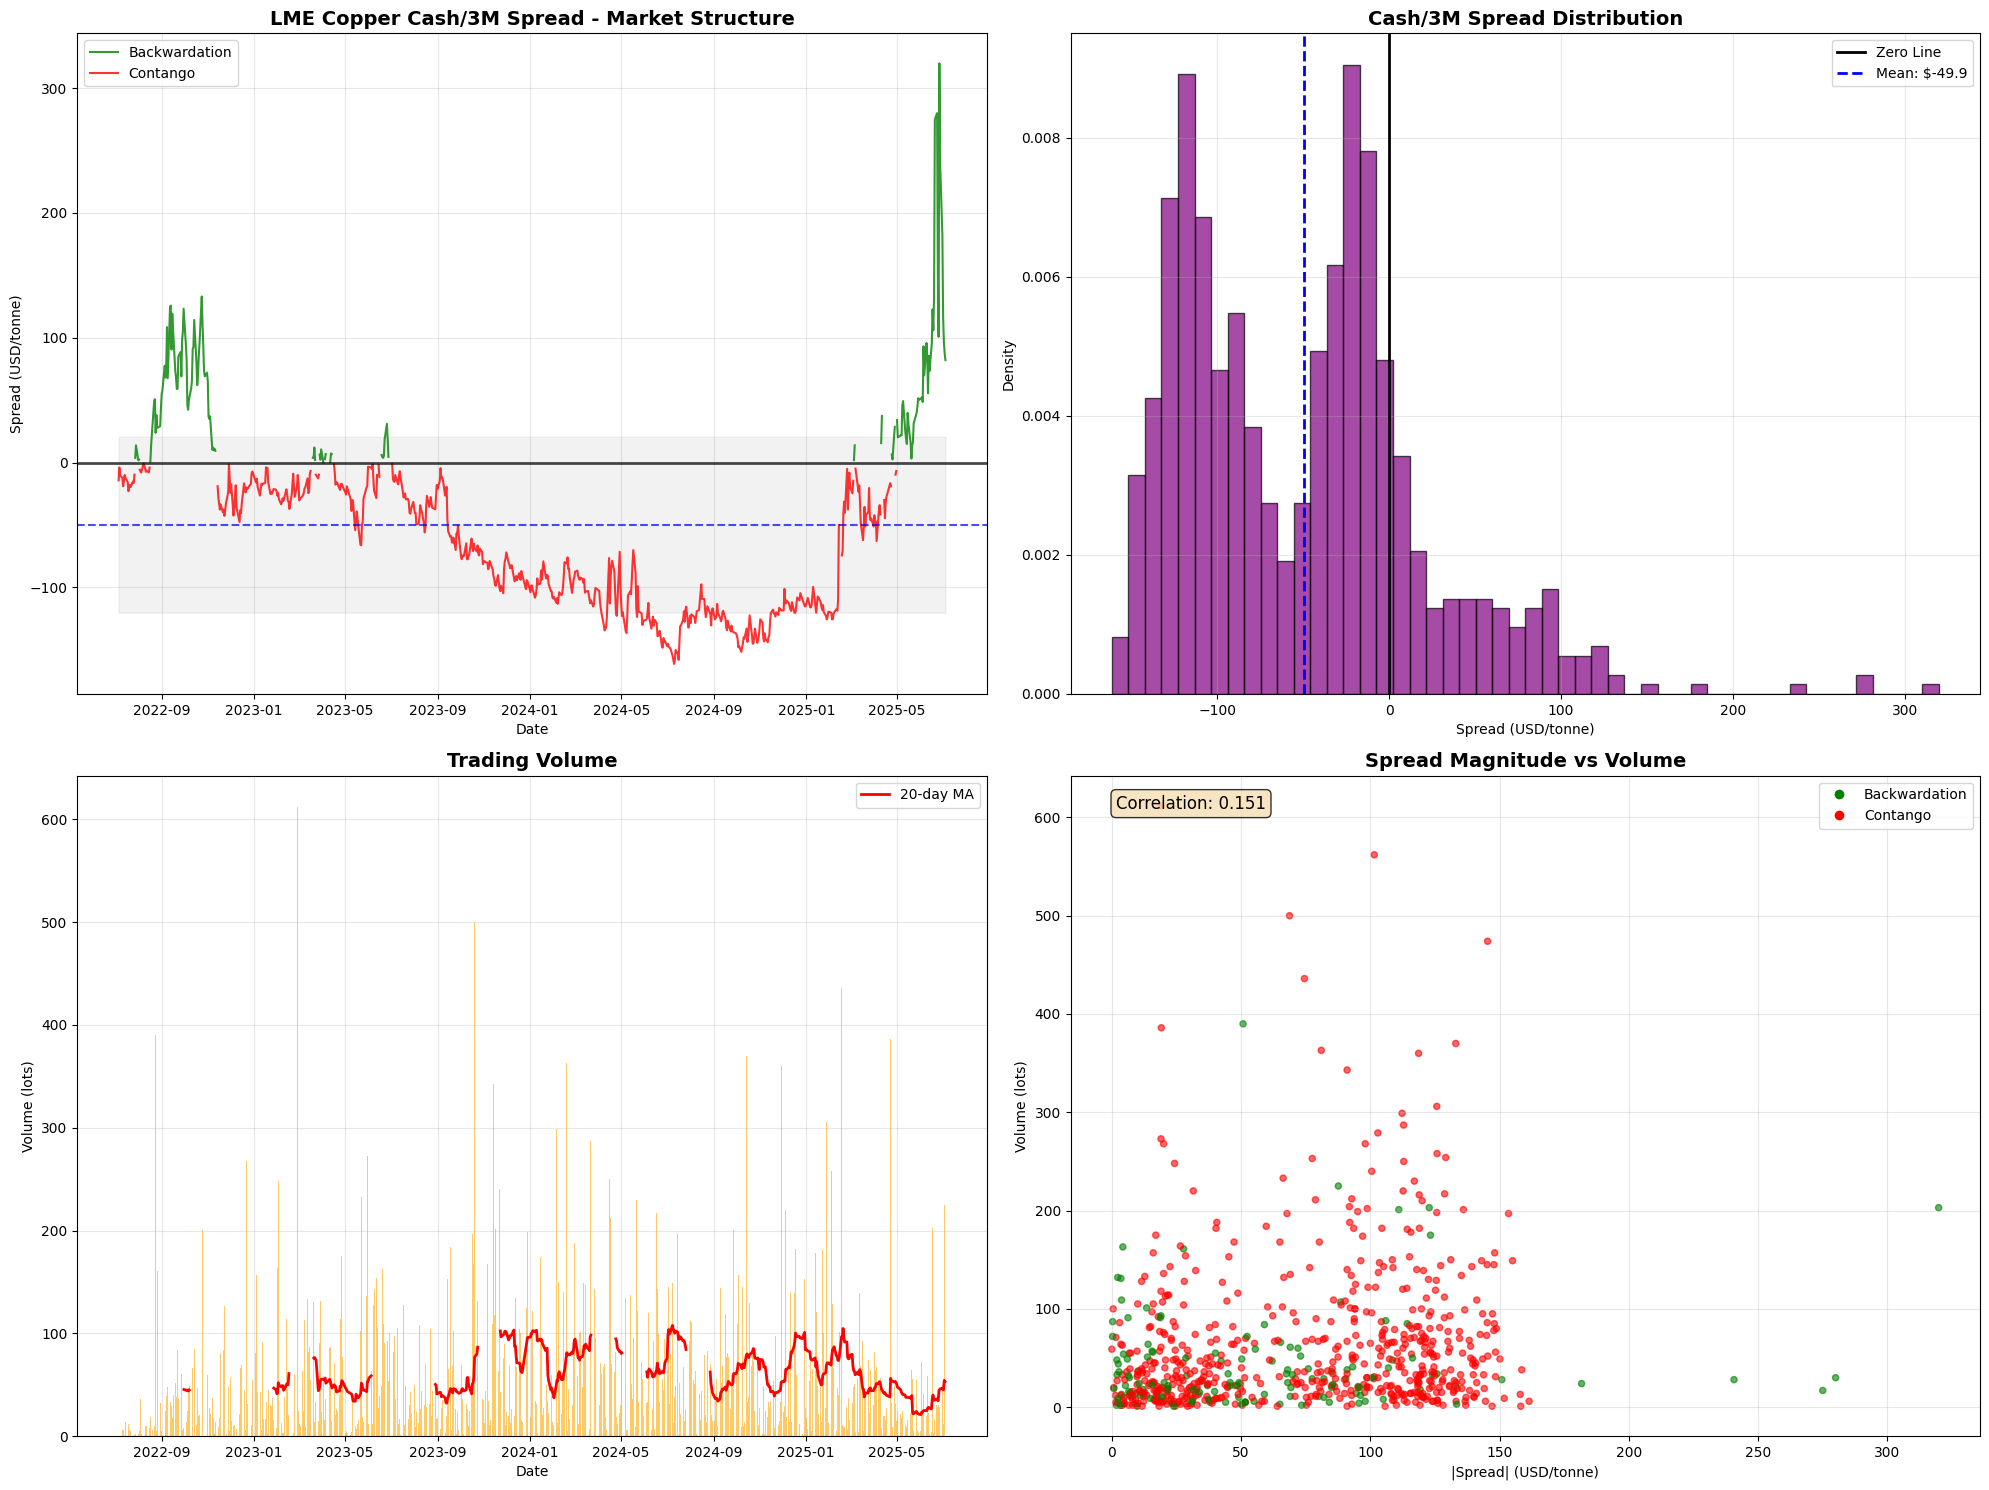

In [3]:
# 基本スプレッドチャートの作成
if cash_3m_spread is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. スプレッド時系列チャート
    # 正値（バックワーデーション）を緑、負値（コンタンゴ）を赤で色分け
    positive_spread = cash_3m_spread['spread_price'].where(cash_3m_spread['spread_price'] >= 0)
    negative_spread = cash_3m_spread['spread_price'].where(cash_3m_spread['spread_price'] < 0)
    
    ax1.plot(cash_3m_spread.index, positive_spread, color='green', linewidth=1.5, alpha=0.8, label='Backwardation')
    ax1.plot(cash_3m_spread.index, negative_spread, color='red', linewidth=1.5, alpha=0.8, label='Contango')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    
    ax1.set_title('LME Copper Cash/3M Spread - Market Structure', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Spread (USD/tonne)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 平均値とレンジ表示
    spread_mean = cash_3m_spread['spread_price'].mean()
    spread_std = cash_3m_spread['spread_price'].std()
    ax1.axhline(y=spread_mean, color='blue', linestyle='--', alpha=0.7, label=f'Average: ${spread_mean:,.1f}')
    ax1.fill_between(cash_3m_spread.index, spread_mean - spread_std, spread_mean + spread_std, 
                     alpha=0.1, color='gray', label='±1 Std Dev')
    
    # 2. スプレッド分布ヒストグラム
    ax2.hist(cash_3m_spread['spread_price'], bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Zero Line')
    ax2.axvline(x=spread_mean, color='blue', linestyle='--', linewidth=2, label=f'Mean: ${spread_mean:.1f}')
    ax2.set_title('Cash/3M Spread Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Spread (USD/tonne)')
    ax2.set_ylabel('Density')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. 出来高チャート
    ax3.bar(cash_3m_spread.index, cash_3m_spread['volume'], alpha=0.6, color='orange', width=1)
    ax3.set_title('Trading Volume', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Volume (lots)')
    ax3.grid(True, alpha=0.3)
    
    # 出来高移動平均線
    volume_ma = cash_3m_spread['volume'].rolling(20).mean()
    ax3.plot(cash_3m_spread.index, volume_ma, color='red', linewidth=2, label='20-day MA')
    ax3.legend()
    
    # 4. スプレッドvs出来高散布図
    # 絶対値でプロット（スプレッドの大きさと出来高の関係）
    spread_abs = abs(cash_3m_spread['spread_price'])
    colors = ['green' if x > 0 else 'red' for x in cash_3m_spread['spread_price']]
    
    ax4.scatter(spread_abs, cash_3m_spread['volume'], alpha=0.6, s=20, c=colors)
    ax4.set_title('Spread Magnitude vs Volume', fontsize=14, fontweight='bold')
    ax4.set_xlabel('|Spread| (USD/tonne)')
    ax4.set_ylabel('Volume (lots)')
    ax4.grid(True, alpha=0.3)
    
    # 相関計算
    correlation = spread_abs.corr(cash_3m_spread['volume'])
    ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax4.transAxes, fontsize=12, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # カラーバーの説明
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Backwardation'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Contango')]
    ax4.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/cash_3m_spread_basic_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2. リターンとボラティリティ分析

### 解釈ガイド:
- **スプレッド変化**: 市場構造の変化速度
- **累積変化**: 長期的な市場構造トレンド
- **ローリングボラティリティ**: 市場ストレスの時間変化
- **変化分布**: 正規分布からの乖離（テールリスク）

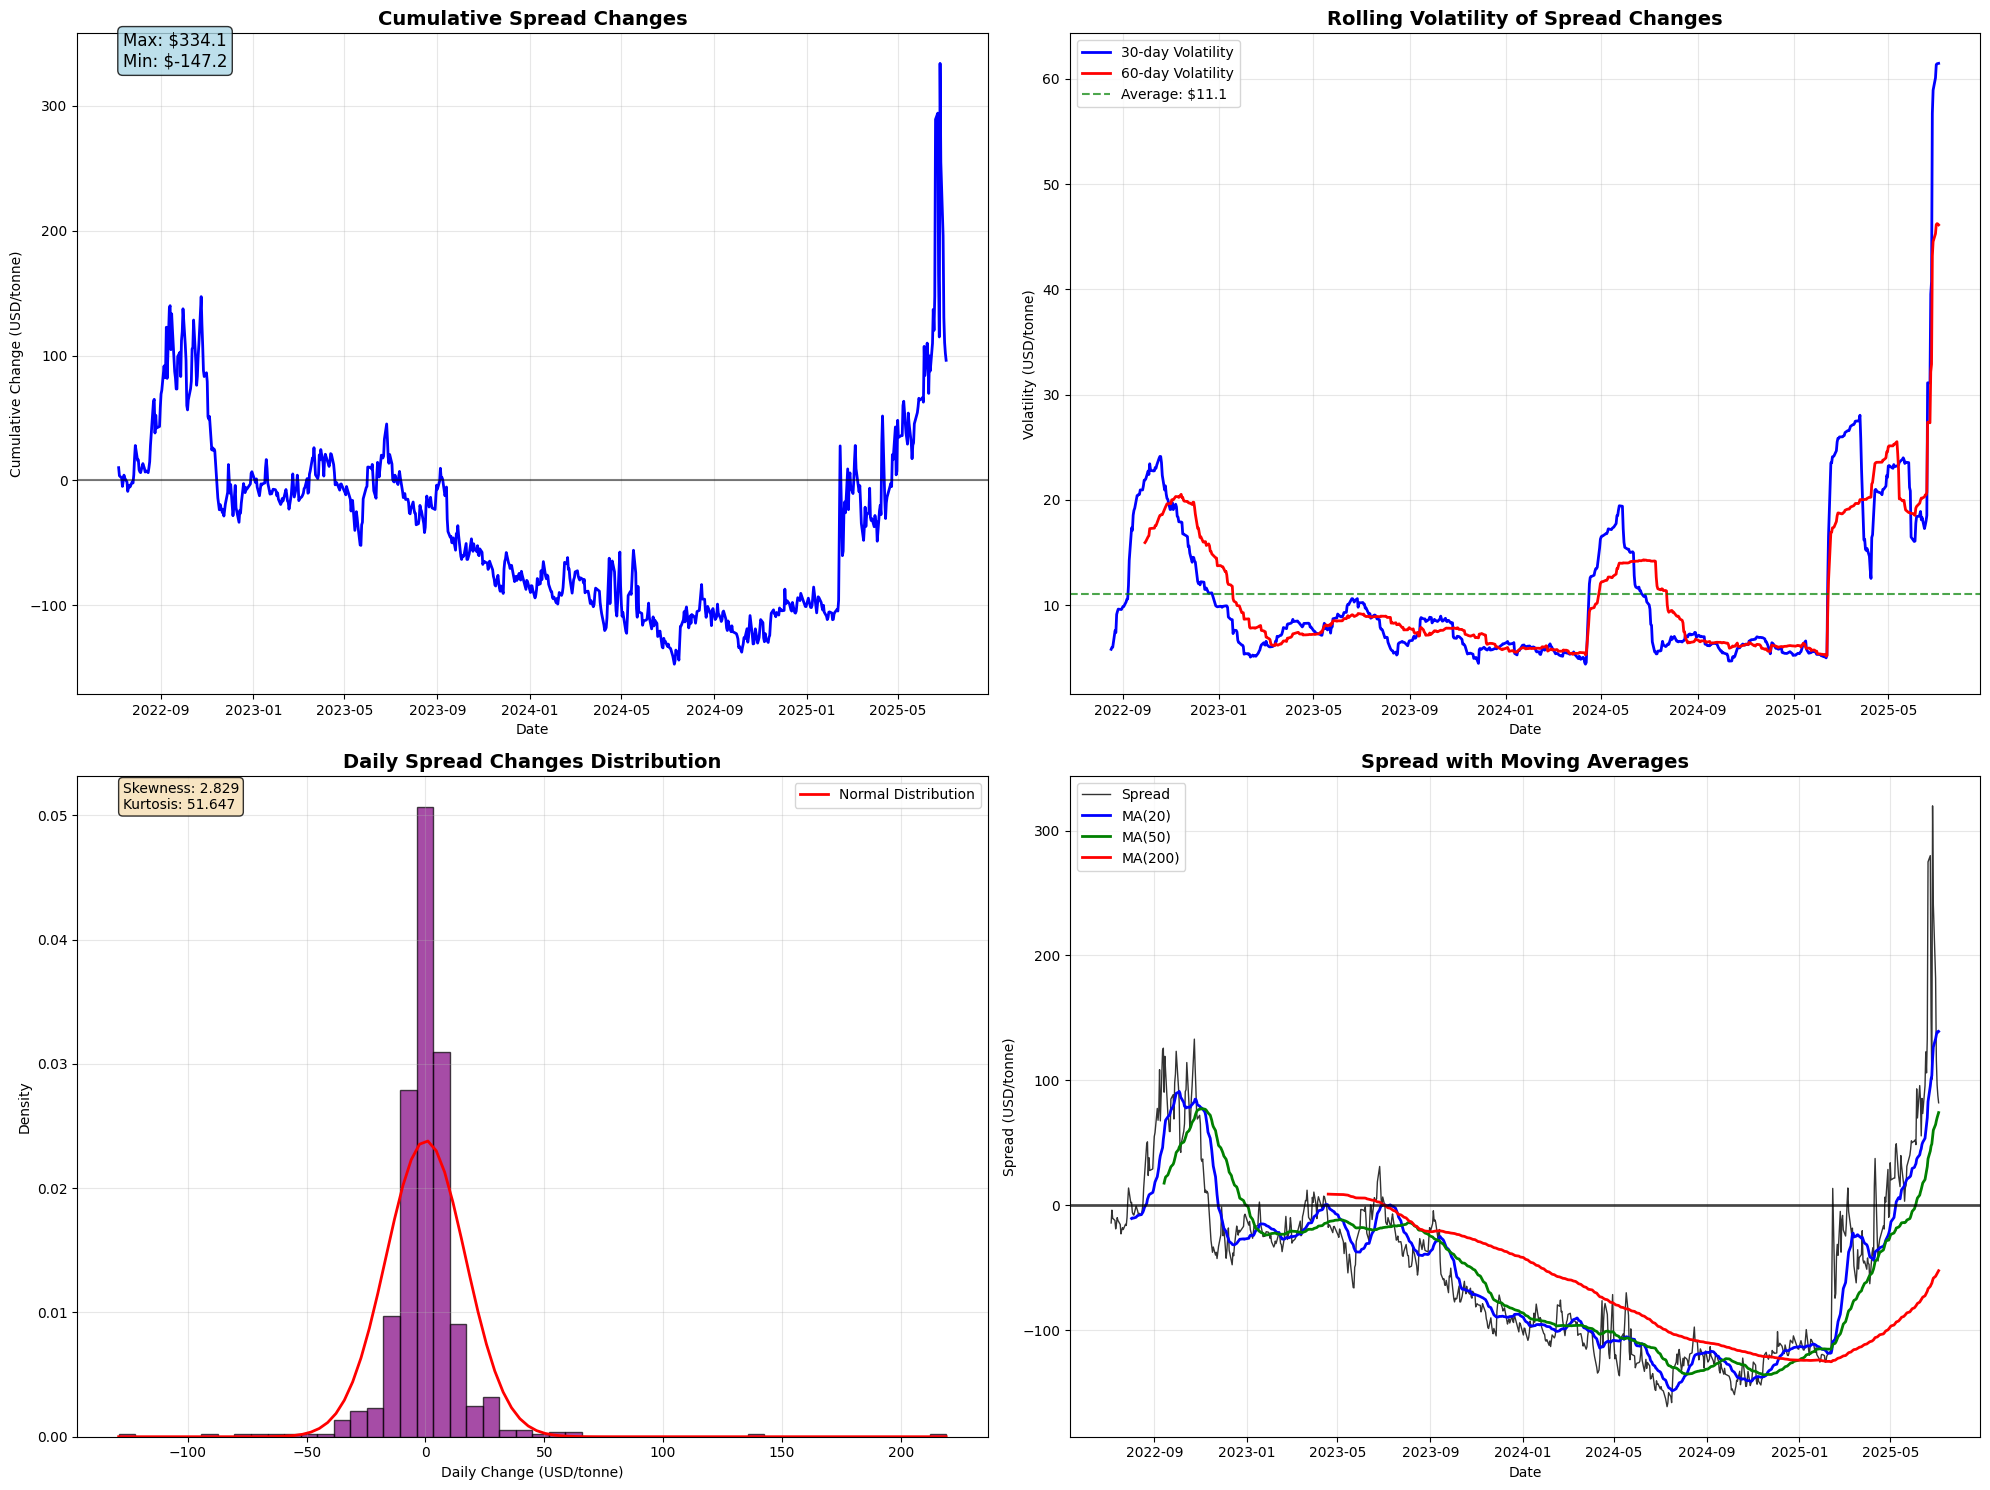


スプレッド変化・ボラティリティ統計:
平均日次変化: $0.13
変化の標準偏差: $16.75
最大上昇: $219.14
最大下落: $-129.12
変化の勝率: 49.2%
VaR (5%): $-17.15
VaR (1%): $-39.52


In [4]:
# スプレッド変化とボラティリティの計算
if cash_3m_spread is not None:
    # 日次変化計算（スプレッドの場合は差分を使用）
    cash_3m_spread['daily_change'] = cash_3m_spread['spread_price'].diff()
    cash_3m_spread['cumulative_change'] = cash_3m_spread['daily_change'].cumsum()
    
    # ローリングボラティリティ計算
    cash_3m_spread['volatility_30d'] = cash_3m_spread['daily_change'].rolling(30).std()
    cash_3m_spread['volatility_60d'] = cash_3m_spread['daily_change'].rolling(60).std()
    
    # 移動平均計算
    cash_3m_spread['ma_20'] = cash_3m_spread['spread_price'].rolling(20).mean()
    cash_3m_spread['ma_50'] = cash_3m_spread['spread_price'].rolling(50).mean()
    cash_3m_spread['ma_200'] = cash_3m_spread['spread_price'].rolling(200).mean()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 累積変化チャート
    ax1.plot(cash_3m_spread.index, cash_3m_spread['cumulative_change'], linewidth=2, color='blue')
    ax1.set_title('Cumulative Spread Changes', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Change (USD/tonne)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 最大・最小の累積変化
    max_change = cash_3m_spread['cumulative_change'].max()
    min_change = cash_3m_spread['cumulative_change'].min()
    ax1.text(0.05, 0.95, f'Max: ${max_change:.1f}\nMin: ${min_change:.1f}', 
             transform=ax1.transAxes, fontsize=12, 
             bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # 2. ローリングボラティリティ
    ax2.plot(cash_3m_spread.index, cash_3m_spread['volatility_30d'], label='30-day Volatility', 
             linewidth=2, color='blue')
    ax2.plot(cash_3m_spread.index, cash_3m_spread['volatility_60d'], label='60-day Volatility', 
             linewidth=2, color='red')
    ax2.set_title('Rolling Volatility of Spread Changes', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volatility (USD/tonne)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 平均ボラティリティライン
    avg_vol = cash_3m_spread['volatility_30d'].mean()
    ax2.axhline(y=avg_vol, color='green', linestyle='--', alpha=0.7, 
                label=f'Average: ${avg_vol:.1f}')
    ax2.legend()
    
    # 3. 日次変化分布
    changes_clean = cash_3m_spread['daily_change'].dropna()
    ax3.hist(changes_clean, bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
    ax3.set_title('Daily Spread Changes Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Daily Change (USD/tonne)')
    ax3.set_ylabel('Density')
    ax3.grid(True, alpha=0.3)
    
    # 正規分布との比較
    mu, sigma = changes_clean.mean(), changes_clean.std()
    x = np.linspace(changes_clean.min(), changes_clean.max(), 100)
    normal_dist = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    
    # 統計情報
    skewness = stats.skew(changes_clean)
    kurtosis = stats.kurtosis(changes_clean)
    ax3.text(0.05, 0.95, f'Skewness: {skewness:.3f}\nKurtosis: {kurtosis:.3f}', 
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    ax3.legend()
    
    # 4. スプレッドと移動平均
    ax4.plot(cash_3m_spread.index, cash_3m_spread['spread_price'], label='Spread', 
             linewidth=1, color='black', alpha=0.8)
    ax4.plot(cash_3m_spread.index, cash_3m_spread['ma_20'], label='MA(20)', 
             linewidth=2, color='blue')
    ax4.plot(cash_3m_spread.index, cash_3m_spread['ma_50'], label='MA(50)', 
             linewidth=2, color='green')
    ax4.plot(cash_3m_spread.index, cash_3m_spread['ma_200'], label='MA(200)', 
             linewidth=2, color='red')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax4.set_title('Spread with Moving Averages', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Spread (USD/tonne)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/cash_3m_spread_changes_volatility.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # スプレッド変化統計サマリー
    print("\nスプレッド変化・ボラティリティ統計:")
    print("=" * 50)
    print(f"平均日次変化: ${cash_3m_spread['daily_change'].mean():.2f}")
    print(f"変化の標準偏差: ${cash_3m_spread['daily_change'].std():.2f}")
    print(f"最大上昇: ${cash_3m_spread['daily_change'].max():.2f}")
    print(f"最大下落: ${cash_3m_spread['daily_change'].min():.2f}")
    print(f"変化の勝率: {(cash_3m_spread['daily_change'] > 0).mean() * 100:.1f}%")
    print(f"VaR (5%): ${np.percentile(changes_clean, 5):.2f}")
    print(f"VaR (1%): ${np.percentile(changes_clean, 1):.2f}")

## 3. テクニカル分析指標

### 解釈ガイド:
- **ボリンジャーバンド**: スプレッドの過大・過小評価判定
- **RSI**: スプレッドの買われすぎ・売られすぎ判定
- **MACD**: スプレッドトレンド転換シグナル
- **ATR**: 平均的なスプレッド変動幅

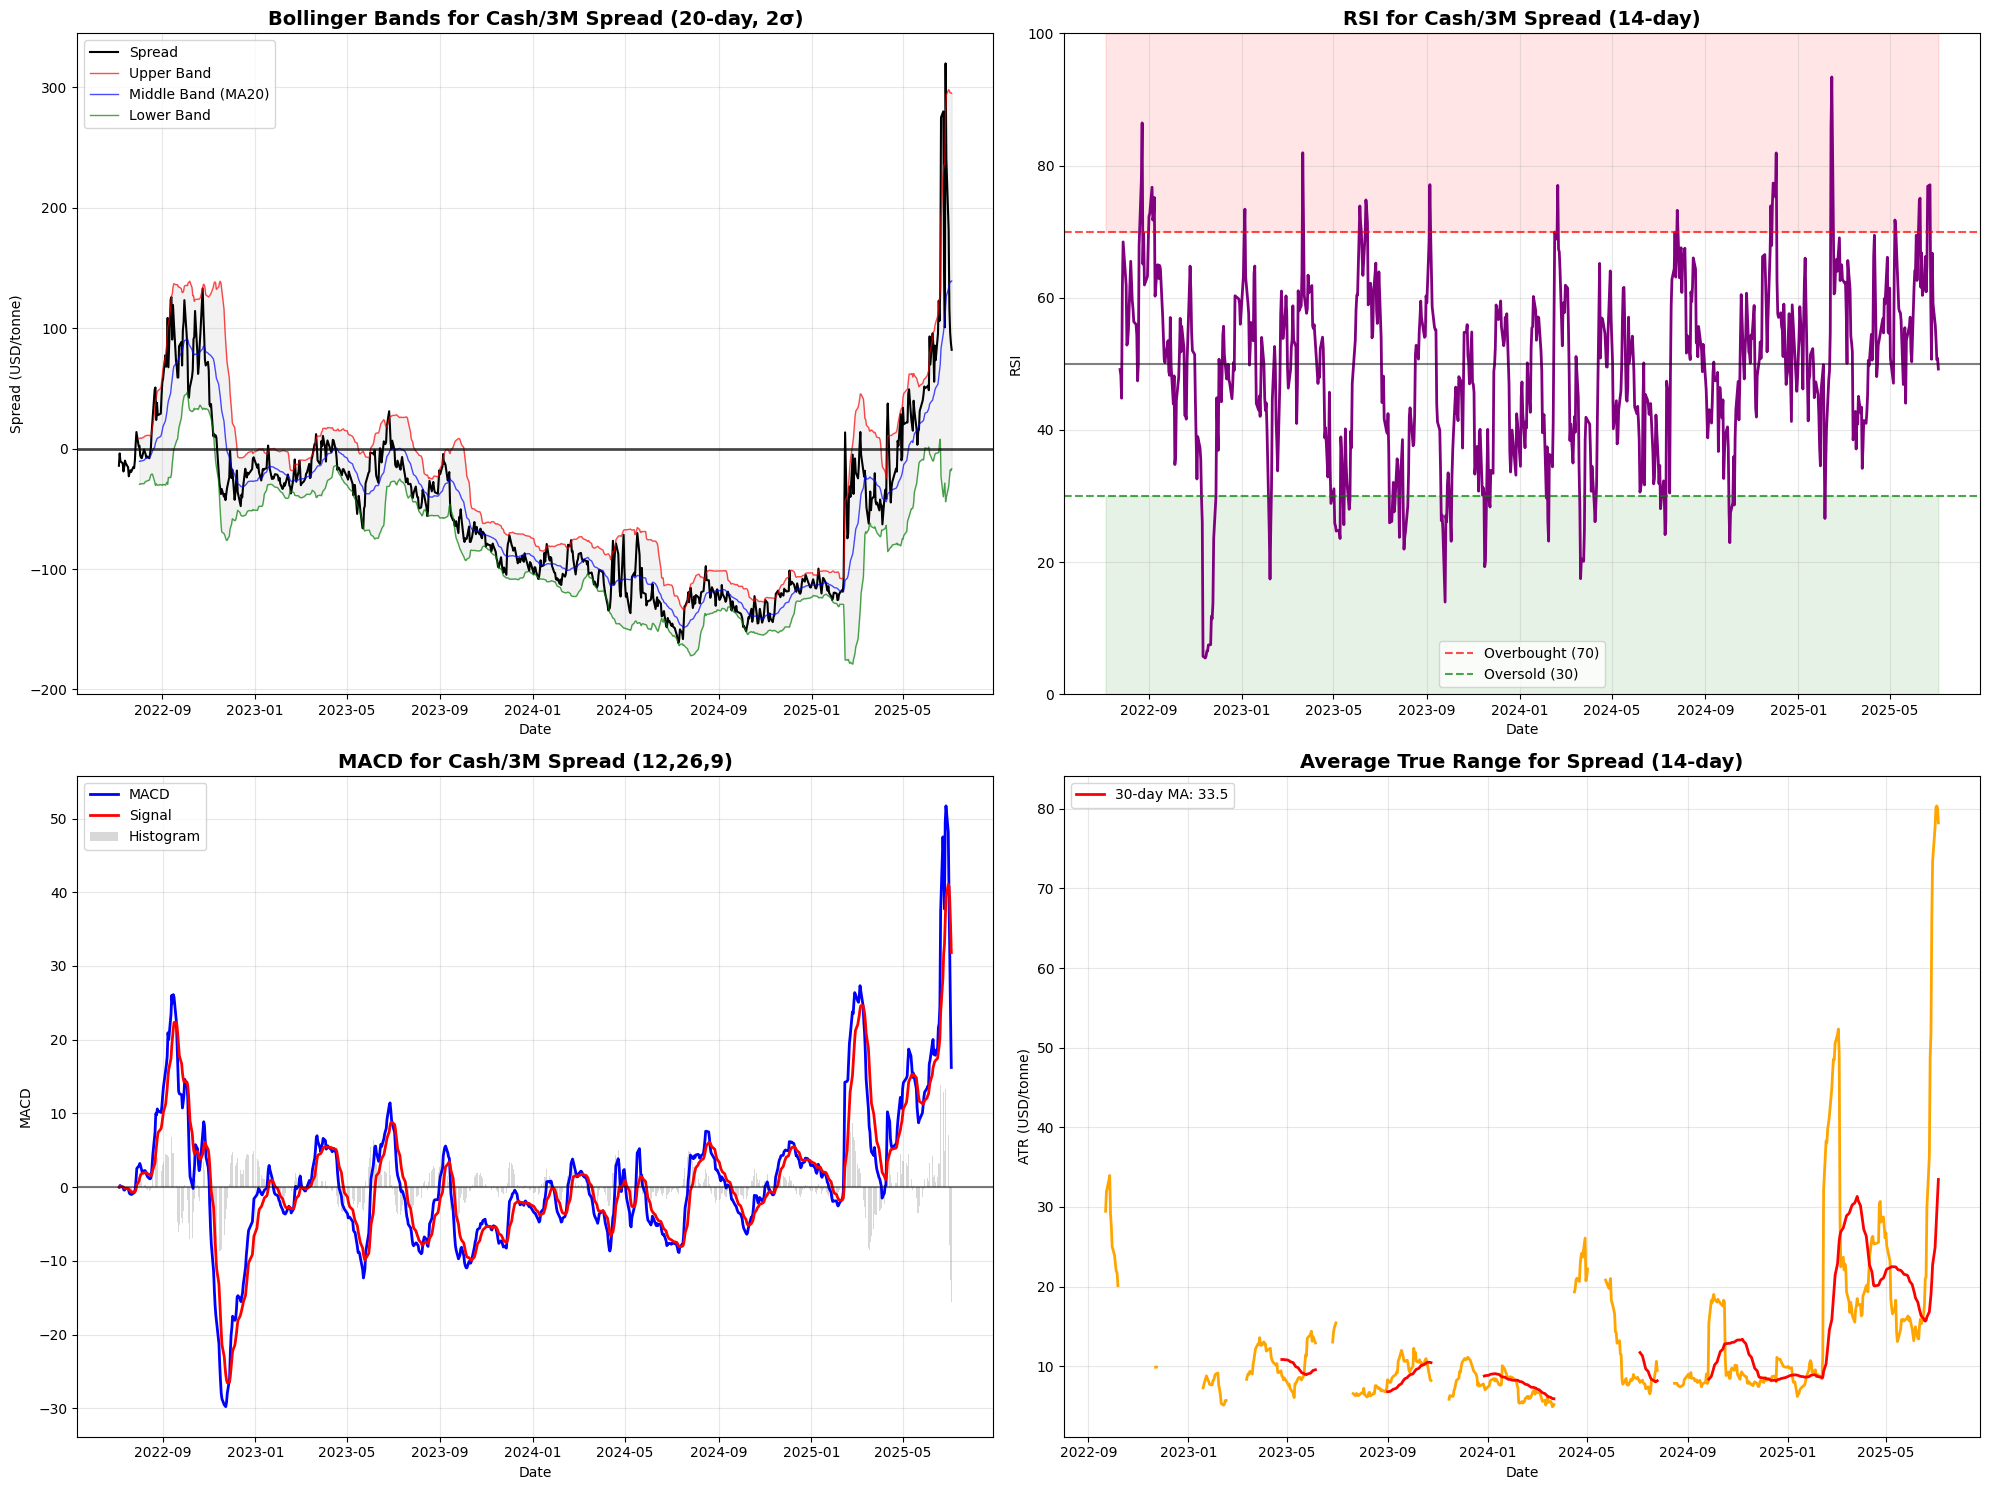


最新のテクニカル指標:
スプレッド: $82.0
RSI: 49.2
MACD: 16.24
MACD Signal: 31.80
ATR: $78.2
ボリンジャーバンド幅: $311.7

ボリンジャーバンド位置: バンド内 (正常範囲)
RSI シグナル: 中立

現在の市場構造: バックワーデーション (需給タイト)


In [5]:
# テクニカル指標の計算（スプレッド用に調整）
def calculate_rsi_spread(prices, period=14):
    """スプレッド用RSI計算"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd_spread(prices, fast=12, slow=26, signal=9):
    """スプレッド用MACD計算"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

def calculate_atr_spread(high, low, close, period=14):
    """スプレッド用ATR計算"""
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

if cash_3m_spread is not None:
    # テクニカル指標計算
    cash_3m_spread['rsi'] = calculate_rsi_spread(cash_3m_spread['spread_price'])
    cash_3m_spread['macd'], cash_3m_spread['macd_signal'], cash_3m_spread['macd_histogram'] = calculate_macd_spread(cash_3m_spread['spread_price'])
    cash_3m_spread['atr'] = calculate_atr_spread(cash_3m_spread['high_price'], cash_3m_spread['low_price'], cash_3m_spread['spread_price'])
    
    # ボリンジャーバンド計算
    bb_period = 20
    bb_std = 2
    cash_3m_spread['bb_middle'] = cash_3m_spread['spread_price'].rolling(bb_period).mean()
    bb_std_val = cash_3m_spread['spread_price'].rolling(bb_period).std()
    cash_3m_spread['bb_upper'] = cash_3m_spread['bb_middle'] + (bb_std_val * bb_std)
    cash_3m_spread['bb_lower'] = cash_3m_spread['bb_middle'] - (bb_std_val * bb_std)
    cash_3m_spread['bb_width'] = (cash_3m_spread['bb_upper'] - cash_3m_spread['bb_lower'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. ボリンジャーバンド
    ax1.plot(cash_3m_spread.index, cash_3m_spread['spread_price'], label='Spread', 
             linewidth=1.5, color='black')
    ax1.plot(cash_3m_spread.index, cash_3m_spread['bb_upper'], label='Upper Band', 
             linewidth=1, color='red', alpha=0.7)
    ax1.plot(cash_3m_spread.index, cash_3m_spread['bb_middle'], label='Middle Band (MA20)', 
             linewidth=1, color='blue', alpha=0.7)
    ax1.plot(cash_3m_spread.index, cash_3m_spread['bb_lower'], label='Lower Band', 
             linewidth=1, color='green', alpha=0.7)
    
    # バンド間を塗りつぶし
    ax1.fill_between(cash_3m_spread.index, cash_3m_spread['bb_upper'], cash_3m_spread['bb_lower'], 
                     alpha=0.1, color='gray')
    
    # ゼロライン
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    
    ax1.set_title('Bollinger Bands for Cash/3M Spread (20-day, 2σ)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Spread (USD/tonne)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. RSI
    ax2.plot(cash_3m_spread.index, cash_3m_spread['rsi'], linewidth=2, color='purple')
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax2.axhline(y=50, color='black', linestyle='-', alpha=0.5)
    ax2.fill_between(cash_3m_spread.index, 70, 100, alpha=0.1, color='red')
    ax2.fill_between(cash_3m_spread.index, 0, 30, alpha=0.1, color='green')
    
    ax2.set_title('RSI for Cash/3M Spread (14-day)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. MACD
    ax3.plot(cash_3m_spread.index, cash_3m_spread['macd'], label='MACD', linewidth=2, color='blue')
    ax3.plot(cash_3m_spread.index, cash_3m_spread['macd_signal'], label='Signal', linewidth=2, color='red')
    ax3.bar(cash_3m_spread.index, cash_3m_spread['macd_histogram'], label='Histogram', 
            alpha=0.3, color='gray', width=1)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax3.set_title('MACD for Cash/3M Spread (12,26,9)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('MACD')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. ATR (スプレッド変動性)
    ax4.plot(cash_3m_spread.index, cash_3m_spread['atr'], linewidth=2, color='orange')
    ax4.set_title('Average True Range for Spread (14-day)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('ATR (USD/tonne)')
    ax4.grid(True, alpha=0.3)
    
    # ATR移動平均
    atr_ma = cash_3m_spread['atr'].rolling(30).mean()
    ax4.plot(cash_3m_spread.index, atr_ma, color='red', linewidth=2, 
             label=f'30-day MA: {atr_ma.iloc[-1]:.1f}')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/cash_3m_spread_technical_indicators.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # テクニカル指標サマリー
    latest_data = cash_3m_spread.iloc[-1]
    print("\n最新のテクニカル指標:")
    print("=" * 40)
    print(f"スプレッド: ${latest_data['spread_price']:.1f}")
    print(f"RSI: {latest_data['rsi']:.1f}")
    print(f"MACD: {latest_data['macd']:.2f}")
    print(f"MACD Signal: {latest_data['macd_signal']:.2f}")
    print(f"ATR: ${latest_data['atr']:.1f}")
    print(f"ボリンジャーバンド幅: ${latest_data['bb_width']:.1f}")
    
    # 現在のスプレッド位置
    if latest_data['spread_price'] > latest_data['bb_upper']:
        bb_position = "上限突破 (バックワーデーション過大)"
    elif latest_data['spread_price'] < latest_data['bb_lower']:
        bb_position = "下限突破 (コンタンゴ過大)"
    else:
        bb_position = "バンド内 (正常範囲)"
    
    print(f"\nボリンジャーバンド位置: {bb_position}")
    
    if latest_data['rsi'] > 70:
        rsi_signal = "買われすぎ (バックワーデーション過大)"
    elif latest_data['rsi'] < 30:
        rsi_signal = "売られすぎ (コンタンゴ過大)"
    else:
        rsi_signal = "中立"
    
    print(f"RSI シグナル: {rsi_signal}")
    
    # 市場構造判定
    if latest_data['spread_price'] > 0:
        market_structure = "バックワーデーション (需給タイト)"
    else:
        market_structure = "コンタンゴ (供給過多)"
    
    print(f"\n現在の市場構造: {market_structure}")

## 4. 季節性・周期性分析

### 解釈ガイド:
- **月別スプレッドパターン**: 季節的な需給変化
- **曜日効果**: 週内でのスプレッド変動
- **年間パターン**: 長期的な市場構造変化
- **カレンダー効果**: 休日・決算期の影響

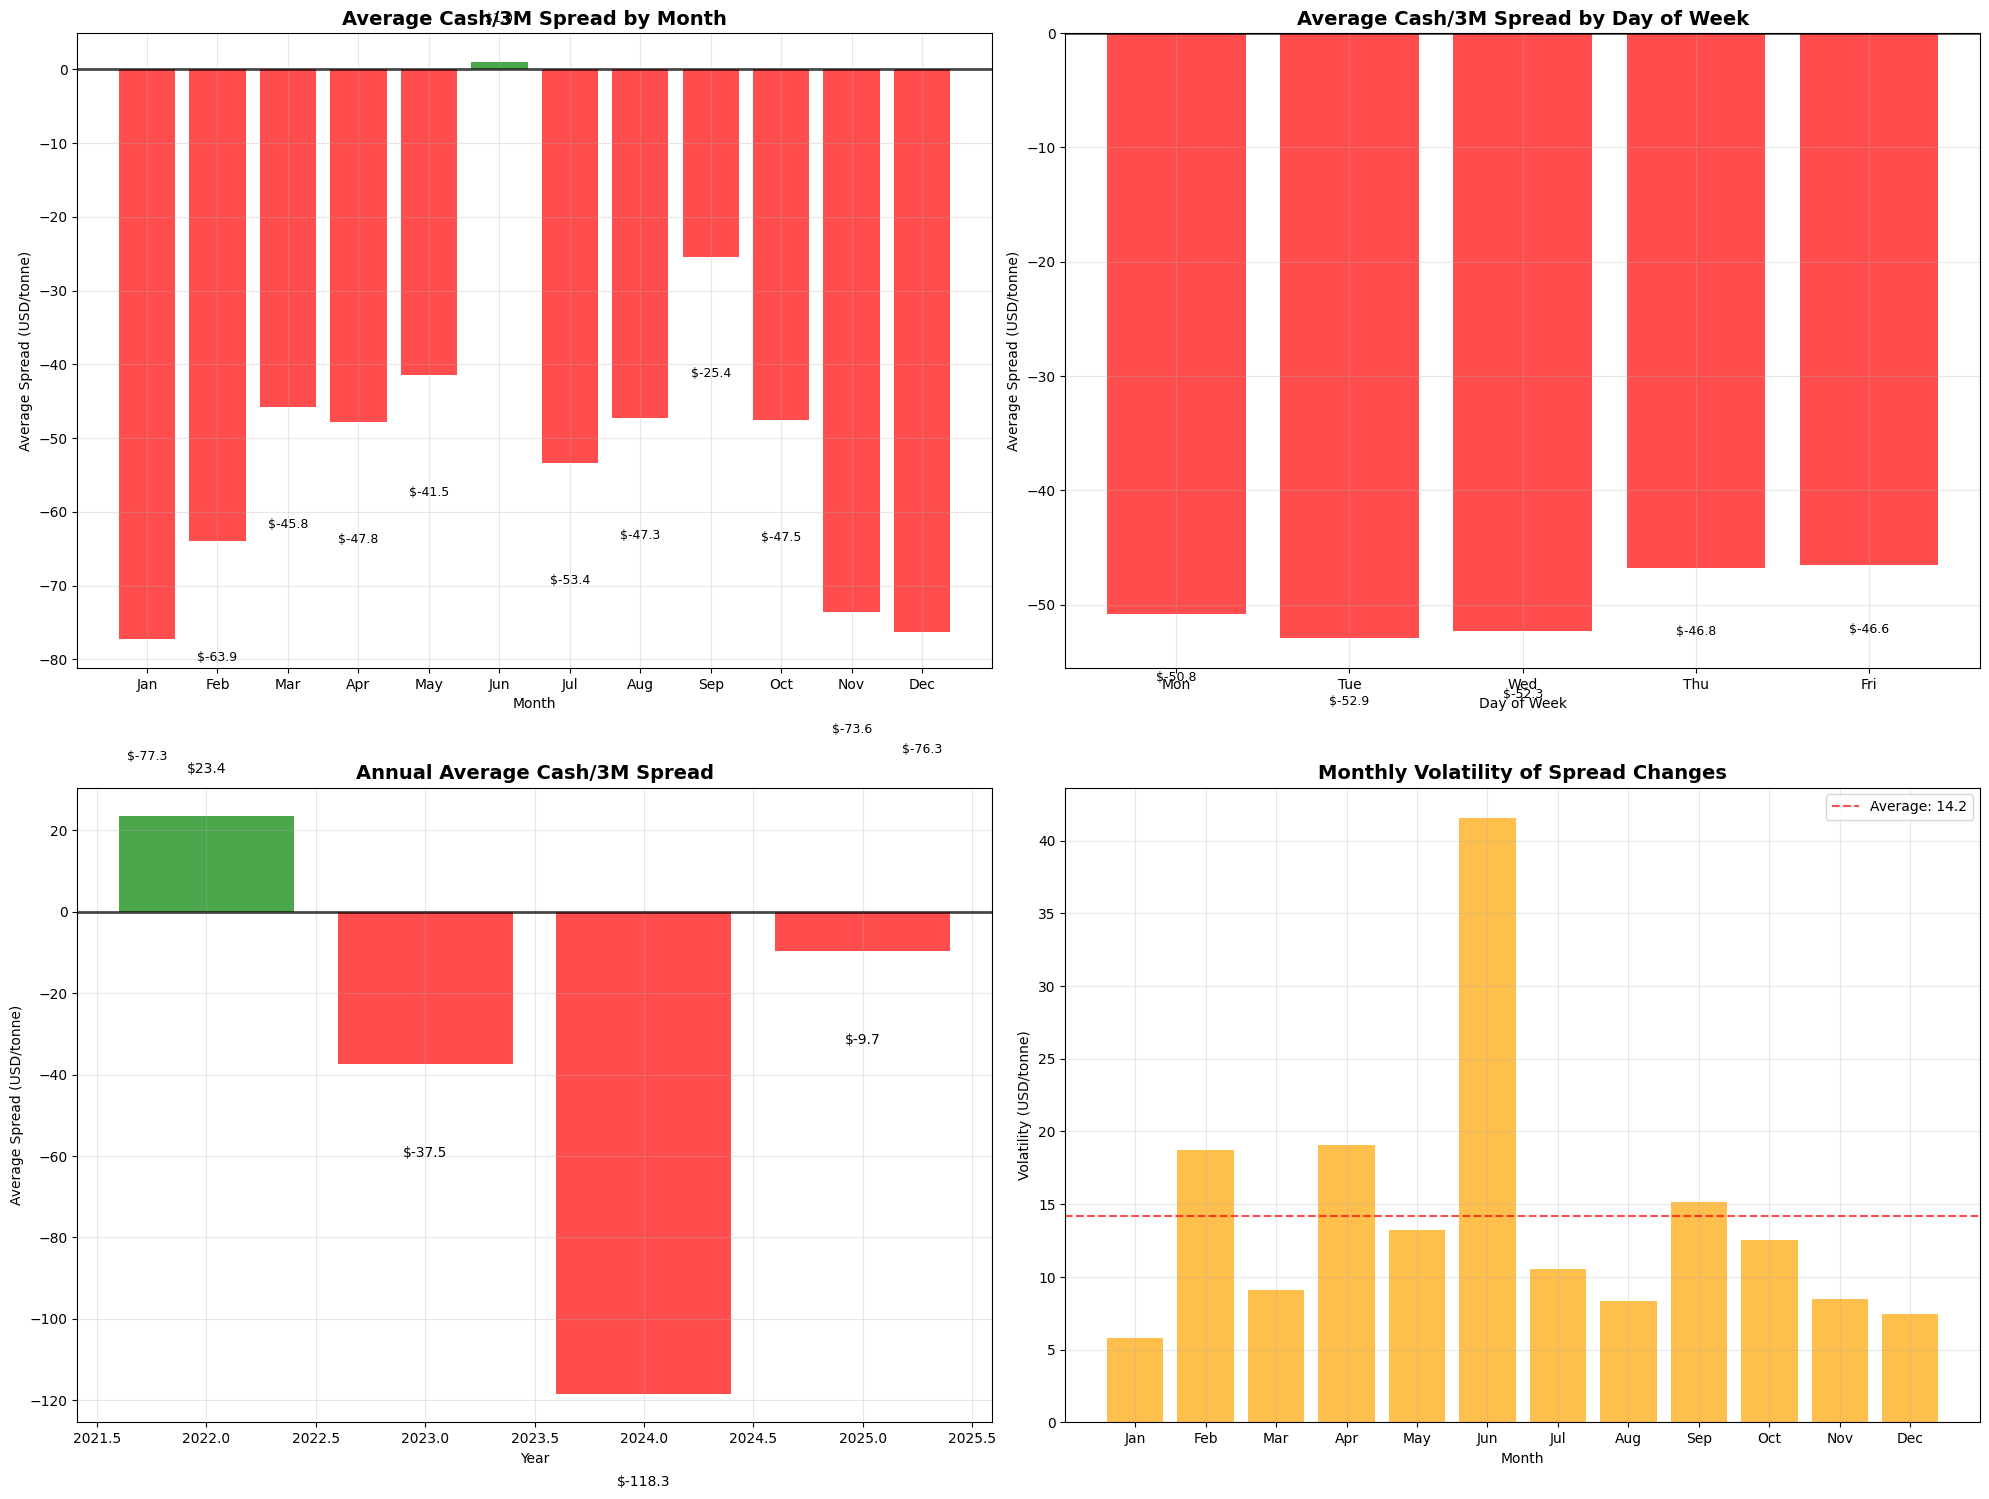


季節性分析サマリー:
最も強いバックワーデーション月: Jun ($1.0)
最も強いコンタンゴ月: Jan ($-77.3)
最も強いバックワーデーション曜日: Fri ($-46.6)
最も強いコンタンゴ曜日: Tue ($-52.9)
最高ボラティリティ月: Jun (41.6)
最低ボラティリティ月: Jan (5.8)
2022年: バックワーデーション 52.8%, コンタンゴ 47.2%
2023年: バックワーデーション 9.2%, コンタンゴ 90.8%
2024年: バックワーデーション 0.0%, コンタンゴ 100.0%
2025年: バックワーデーション 41.4%, コンタンゴ 58.6%


In [6]:
# 季節性分析
if cash_3m_spread is not None:
    # 日付関連の特徴量作成
    cash_3m_spread['month'] = cash_3m_spread.index.month
    cash_3m_spread['day_of_week'] = cash_3m_spread.index.dayofweek  # 0=Monday, 6=Sunday
    cash_3m_spread['quarter'] = cash_3m_spread.index.quarter
    cash_3m_spread['year'] = cash_3m_spread.index.year
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 月別平均スプレッド
    monthly_spread = cash_3m_spread.groupby('month')['spread_price'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    colors = ['green' if x > 0 else 'red' for x in monthly_spread]
    bars1 = ax1.bar(range(1, 13), monthly_spread, color=colors, alpha=0.7)
    ax1.set_title('Average Cash/3M Spread by Month', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Spread (USD/tonne)')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(month_names)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax1.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, spread in zip(bars1, monthly_spread):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (5 if spread > 0 else -15),
                 f'${spread:.1f}', ha='center', va='bottom' if spread > 0 else 'top', fontsize=9)
    
    # 2. 曜日別平均スプレッド
    daily_spread = cash_3m_spread.groupby('day_of_week')['spread_price'].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    
    colors2 = ['green' if x > 0 else 'red' for x in daily_spread]
    bars2 = ax2.bar(range(5), daily_spread, color=colors2, alpha=0.7)
    ax2.set_title('Average Cash/3M Spread by Day of Week', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Average Spread (USD/tonne)')
    ax2.set_xticks(range(5))
    ax2.set_xticklabels(day_names)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax2.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, spread in zip(bars2, daily_spread):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (2 if spread > 0 else -5),
                 f'${spread:.1f}', ha='center', va='bottom' if spread > 0 else 'top', fontsize=9)
    
    # 3. 年別平均スプレッド
    yearly_spread = cash_3m_spread.groupby('year')['spread_price'].mean()
    colors3 = ['green' if x > 0 else 'red' for x in yearly_spread]
    bars3 = ax3.bar(yearly_spread.index, yearly_spread, color=colors3, alpha=0.7)
    ax3.set_title('Annual Average Cash/3M Spread', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Average Spread (USD/tonne)')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=2)
    ax3.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, spread in zip(bars3, yearly_spread):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (10 if spread > 0 else -20),
                 f'${spread:.1f}', ha='center', va='bottom' if spread > 0 else 'top', fontsize=10)
    
    # 4. 月別ボラティリティ
    monthly_vol = cash_3m_spread.groupby('month')['daily_change'].std()
    
    ax4.bar(range(1, 13), monthly_vol, color='orange', alpha=0.7)
    ax4.set_title('Monthly Volatility of Spread Changes', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Volatility (USD/tonne)')
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels(month_names)
    ax4.grid(True, alpha=0.3)
    
    # 平均ボラティリティライン
    avg_monthly_vol = monthly_vol.mean()
    ax4.axhline(y=avg_monthly_vol, color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_monthly_vol:.1f}')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/cash_3m_spread_seasonality.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 季節性サマリー
    print("\n季節性分析サマリー:")
    print("=" * 50)
    
    best_month = monthly_spread.idxmax()
    worst_month = monthly_spread.idxmin()
    print(f"最も強いバックワーデーション月: {month_names[best_month-1]} (${monthly_spread[best_month]:.1f})")
    print(f"最も強いコンタンゴ月: {month_names[worst_month-1]} (${monthly_spread[worst_month]:.1f})")
    
    best_day = daily_spread.idxmax()
    worst_day = daily_spread.idxmin()
    print(f"最も強いバックワーデーション曜日: {day_names[best_day]} (${daily_spread[best_day]:.1f})")
    print(f"最も強いコンタンゴ曜日: {day_names[worst_day]} (${daily_spread[worst_day]:.1f})")
    
    high_vol_month = monthly_vol.idxmax()
    low_vol_month = monthly_vol.idxmin()
    print(f"最高ボラティリティ月: {month_names[high_vol_month-1]} ({monthly_vol[high_vol_month]:.1f})")
    print(f"最低ボラティリティ月: {month_names[low_vol_month-1]} ({monthly_vol[low_vol_month]:.1f})")
    
    # バックワーデーション/コンタンゴの頻度
    for year in yearly_spread.index:
        year_data = cash_3m_spread[cash_3m_spread['year'] == year]
        backwardation_pct = (year_data['spread_price'] > 0).mean() * 100
        print(f"{year}年: バックワーデーション {backwardation_pct:.1f}%, コンタンゴ {100-backwardation_pct:.1f}%")

## 5. 総合ダッシュボード・サマリー

### 投資・トレーディング戦略への含意:
1. **市場構造分析**: バックワーデーション/コンタンゴの判定
2. **スプレッド取引**: 異常値での逆張り戦略
3. **ヘッジング**: 価格リスクのヘッジ効果測定
4. **季節性活用**: 月別・曜日別の戦略調整
5. **リスク管理**: スプレッドボラティリティ管理

In [7]:
# 総合サマリーレポート
if cash_3m_spread is not None:
    print("=" * 80)
    print("LME銅 Cash/3Mスプレッド 総合分析レポート")
    print("=" * 80)
    
    latest = cash_3m_spread.iloc[-1]
    first = cash_3m_spread.iloc[0]
    
    print(f"\n【基本情報】")
    print(f"分析期間: {cash_3m_spread.index.min().date()} ～ {cash_3m_spread.index.max().date()}")
    print(f"データ数: {len(cash_3m_spread):,}日")
    print(f"最新スプレッド: ${latest['spread_price']:,.1f}/tonne")
    print(f"期間変化: ${latest['spread_price'] - first['spread_price']:+.1f}")
    
    print(f"\n【スプレッド統計】")
    print(f"平均スプレッド: ${cash_3m_spread['spread_price'].mean():,.1f}")
    print(f"最大スプレッド: ${cash_3m_spread['high_price'].max():,.1f} ({cash_3m_spread['high_price'].idxmax().date()})")
    print(f"最小スプレッド: ${cash_3m_spread['low_price'].min():,.1f} ({cash_3m_spread['low_price'].idxmin().date()})")
    print(f"スプレッドレンジ: ${cash_3m_spread['high_price'].max() - cash_3m_spread['low_price'].min():,.1f}")
    
    print(f"\n【市場構造】")
    total_days = len(cash_3m_spread)
    backwardation_days = (cash_3m_spread['spread_price'] > 0).sum()
    contango_days = (cash_3m_spread['spread_price'] < 0).sum()
    
    print(f"バックワーデーション: {backwardation_days}日 ({backwardation_days/total_days*100:.1f}%)")
    print(f"コンタンゴ: {contango_days}日 ({contango_days/total_days*100:.1f}%)")
    print(f"平均バックワーデーション強度: ${cash_3m_spread[cash_3m_spread['spread_price'] > 0]['spread_price'].mean():.1f}")
    print(f"平均コンタンゴ強度: ${cash_3m_spread[cash_3m_spread['spread_price'] < 0]['spread_price'].mean():.1f}")
    
    print(f"\n【リスク・変動性】")
    spread_volatility = cash_3m_spread['daily_change'].std()
    max_change_up = cash_3m_spread['daily_change'].max()
    max_change_down = cash_3m_spread['daily_change'].min()
    
    print(f"日次変動の標準偏差: ${spread_volatility:.2f}")
    print(f"最大日次上昇: ${max_change_up:.1f}")
    print(f"最大日次下落: ${max_change_down:.1f}")
    print(f"変動の勝率: {(cash_3m_spread['daily_change'] > 0).mean() * 100:.1f}%")
    
    print(f"\n【出来高分析】")
    print(f"平均出来高: {cash_3m_spread['volume'].mean():,.0f}ロット")
    print(f"最大出来高: {cash_3m_spread['volume'].max():,.0f}ロット ({cash_3m_spread['volume'].idxmax().date()})")
    
    # スプレッドレベル別の出来高分析
    high_backwardation = cash_3m_spread[cash_3m_spread['spread_price'] > cash_3m_spread['spread_price'].quantile(0.8)]
    high_contango = cash_3m_spread[cash_3m_spread['spread_price'] < cash_3m_spread['spread_price'].quantile(0.2)]
    
    print(f"強いバックワーデーション時の平均出来高: {high_backwardation['volume'].mean():,.0f}ロット")
    print(f"強いコンタンゴ時の平均出来高: {high_contango['volume'].mean():,.0f}ロット")
    
    print(f"\n【テクニカル指標 (最新)】")
    print(f"スプレッド: ${latest['spread_price']:.1f}")
    print(f"RSI (14): {latest['rsi']:.1f}")
    print(f"MACD: {latest['macd']:.2f}")
    print(f"ATR (14): ${latest['atr']:.1f}")
    print(f"30日ボラティリティ: ${latest['volatility_30d']:.1f}")
    
    # 現在の市場状況判定
    print(f"\n【市場状況判定】")
    
    # 市場構造判定
    if latest['spread_price'] > 0:
        if latest['spread_price'] > cash_3m_spread['spread_price'].quantile(0.8):
            structure_status = "強いバックワーデーション (需給非常にタイト)"
        else:
            structure_status = "バックワーデーション (需給タイト)"
    else:
        if latest['spread_price'] < cash_3m_spread['spread_price'].quantile(0.2):
            structure_status = "強いコンタンゴ (供給過多)"
        else:
            structure_status = "コンタンゴ (供給余剰)"
    
    print(f"市場構造: {structure_status}")
    
    # トレンド判定
    if latest['spread_price'] > latest['ma_50']:
        trend = "バックワーデーション強化トレンド"
    else:
        trend = "コンタンゴ強化トレンド"
    
    print(f"中期トレンド (50日): {trend}")
    
    # ボラティリティ状況
    current_vol = latest['volatility_30d']
    avg_vol = cash_3m_spread['volatility_30d'].mean()
    
    if current_vol > avg_vol * 1.2:
        vol_status = "高ボラティリティ (市場ストレス)"
    elif current_vol < avg_vol * 0.8:
        vol_status = "低ボラティリティ (安定)"
    else:
        vol_status = "通常ボラティリティ"
    
    print(f"ボラティリティ状況: {vol_status}")
    
    print(f"\n【トレーディング推奨事項】")
    
    # スプレッド取引戦略
    if latest['spread_price'] > cash_3m_spread['spread_price'].quantile(0.9):
        print("1. 戦略: スプレッド売り検討 (極端なバックワーデーション)")
        print("   - Cash売り + 3M買いのペア取引")
    elif latest['spread_price'] < cash_3m_spread['spread_price'].quantile(0.1):
        print("1. 戦略: スプレッド買い検討 (極端なコンタンゴ)")
        print("   - Cash買い + 3M売りのペア取引")
    else:
        print("1. 戦略: トレンドフォロー推奨 (正常範囲内)")
    
    print(f"2. ポジションサイズ: ATRベースで調整 (${latest['atr']:.1f}基準)")
    print(f"3. ストップロス: ATRの1.5倍 (約${latest['atr'] * 1.5:.1f})")
    print(f"4. 利食い目標: ATRの2-3倍 (約${latest['atr'] * 2.5:.1f})")
    
    # 季節性考慮
    current_month = latest.name.month
    monthly_avg = cash_3m_spread.groupby('month')['spread_price'].mean()
    seasonal_bias = monthly_avg[current_month]
    
    if seasonal_bias > 0:
        print(f"5. 季節性: {current_month}月は歴史的にバックワーデーション傾向 (${seasonal_bias:.1f})")
    else:
        print(f"5. 季節性: {current_month}月は歴史的にコンタンゴ傾向 (${seasonal_bias:.1f})")
    
    print(f"\n【リスク管理】")
    print(f"- VaR (5%): ${np.percentile(cash_3m_spread['daily_change'].dropna(), 5):.1f}")
    print(f"- VaR (1%): ${np.percentile(cash_3m_spread['daily_change'].dropna(), 1):.1f}")
    print(f"- 想定最大損失: ${latest['atr'] * 2:.1f} (ATR 2倍)")
    
    print(f"\n{'='*80}")
    print("分析完了: LME銅Cash/3Mスプレッドの包括的な市場理解を提供")
    print(f"{'='*80}")

LME銅 Cash/3Mスプレッド 総合分析レポート

【基本情報】
分析期間: 2022-07-06 ～ 2025-07-04
データ数: 758日
最新スプレッド: $82.0/tonne
期間変化: $+96.2

【スプレッド統計】
平均スプレッド: $-49.9
最大スプレッド: $379.0 (2025-06-23)
最小スプレッド: $-179.5 (2024-09-30)
スプレッドレンジ: $558.5

【市場構造】
バックワーデーション: 142日 (18.7%)
コンタンゴ: 615日 (81.1%)
平均バックワーデーション強度: $57.1
平均コンタンゴ強度: $-74.6

【リスク・変動性】
日次変動の標準偏差: $16.75
最大日次上昇: $219.1
最大日次下落: $-129.1
変動の勝率: 49.2%

【出来高分析】
平均出来高: 61ロット
最大出来高: 612ロット (2023-02-27)
強いバックワーデーション時の平均出来高: 44ロット
強いコンタンゴ時の平均出来高: 69ロット

【テクニカル指標 (最新)】
スプレッド: $82.0
RSI (14): 49.2
MACD: 16.24
ATR (14): $78.2
30日ボラティリティ: $61.5

【市場状況判定】
市場構造: 強いバックワーデーション (需給非常にタイト)
中期トレンド (50日): バックワーデーション強化トレンド
ボラティリティ状況: 高ボラティリティ (市場ストレス)

【トレーディング推奨事項】
1. 戦略: スプレッド売り検討 (極端なバックワーデーション)
   - Cash売り + 3M買いのペア取引
2. ポジションサイズ: ATRベースで調整 ($78.2基準)
3. ストップロス: ATRの1.5倍 (約$117.4)
4. 利食い目標: ATRの2-3倍 (約$195.6)
5. 季節性: 7月は歴史的にコンタンゴ傾向 ($-53.4)

【リスク管理】
- VaR (5%): $-17.1
- VaR (1%): $-39.5
- 想定最大損失: $156.5 (ATR 2倍)

分析完了: LME銅Cash/3Mスプレッドの包括的な市場理解を提供
